## Predicting price of house or room

For predicting Airbnb house or room, we are building some sort of predictive model.

To get started let's read in the necessary libraries and take a look at some of our columns of interest.

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline

In [4]:
df= pd.read_csv('AB_NYC_2019.csv')

In [5]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
id                                48895 non-null int64
name                              48879 non-null object
host_id                           48895 non-null int64
host_name                         48874 non-null object
neighbourhood_group               48895 non-null object
neighbourhood                     48895 non-null object
latitude                          48895 non-null float64
longitude                         48895 non-null float64
room_type                         48895 non-null object
price                             48895 non-null int64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
last_review                       38843 non-null object
reviews_per_month                 38843 non-null float64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-null int64

In [7]:
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [8]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


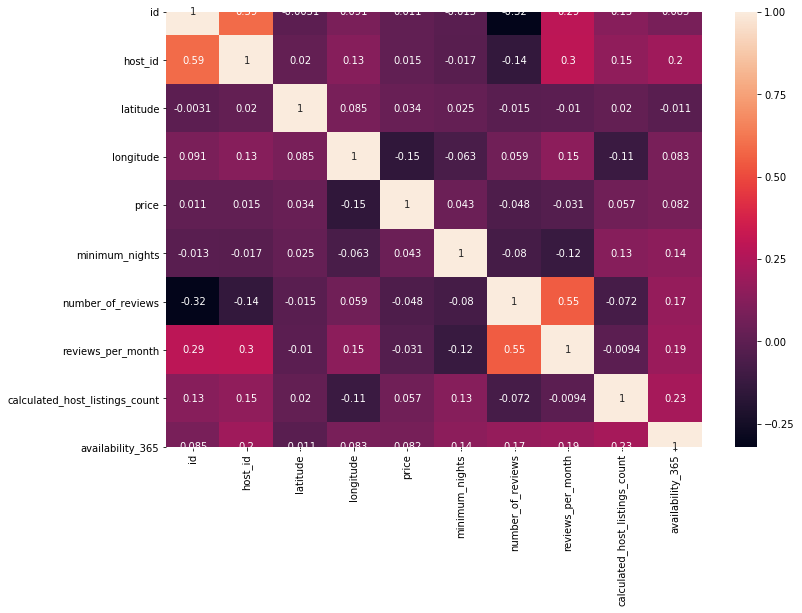

In [9]:
corr = df.corr(method='pearson')
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True);

In [10]:
#Here, we dooing some feature engineering to expand our colum of interest

In [11]:
#There are records with “price” = 0 which is unrealistic as this means no need to pay to stay. 
#So, these records should be removed.
df[df['price']==0]['neighbourhood_group'].count()

df.drop(df[df['price'] == 0].index, inplace = True) 


#In describe method maximum of 'minimum_nights'is 1250 which I believe is unrealistic (is this still an Airbnb or just another rental contract?).
df[df['minimum_nights'] > 365].count()

# I put a threshold as 365 days. Any records with “minimum_nights” larger than 365 will also be removed.
df.drop(df[df['minimum_nights'] > 365].index,inplace = True)



In [13]:
#make a copy data frame df
df_demo=df.copy()

In [14]:
#review per month NaN values replace by 0
df_demo.fillna({'reviews_per_month':0}, inplace=True)
df_demo['no_review']=df_demo['reviews_per_month']==0

#guest uses the room for mostly a year 
df_demo['all_year_avail'] = df_demo['availability_365']>353

#guests stay less than 12 days create a colum as low available
df_demo['low_avail'] = df_demo['availability_365']< 12

#replaces the true and false value with 1 and 0
df_demo['no_review']=df_demo['no_review'].apply(lambda x: 1 if x==True else 0)
df_demo['all_year_avail']=df_demo['all_year_avail'].apply(lambda x: 1 if x== True else 0)
df_demo['low_avail']=df_demo['low_avail'].apply(lambda x: 1 if x==True else 0)
   

In [17]:
#droping unnecesary columns of data frame
df_demo.drop(['id', 'host_id','name','host_name','neighbourhood','last_review'],axis=1,inplace=True)

In [18]:
df_demo.head(2)

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,all_year_avail,no_review,low_avail
0,Brooklyn,40.64749,-73.97237,Private room,149,1,9,0.21,6,365,1,0,0
1,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355,1,0,0


In [19]:
#creating dummy variables for categorical columns 
cat_vars_int = df_demo.select_dtypes(include=['object']).copy().columns

# for each category column add dummy var, drop original column
for var in cat_vars_int:
    df_demo = pd.concat([df_demo.drop(var, axis=1), pd.get_dummies(df_demo[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)

df_demo.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,all_year_avail,no_review,low_avail,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Private room,room_type_Shared room
count,48870.000000,48870.000000,48870.000000,48870.000000,48870.000000,48870.000000,48870.000000,48870.000000,48870.000000,48870.000000,48870.000000,48870.000000,48870.000000,48870.000000,48870.000000,48870.00000,48870.000000
mean,40.728952,-73.952172,152.759402,6.840311,23.277143,1.091070,7.146286,112.728443,0.062738,0.205504,0.415695,0.411070,0.443094,0.115899,0.007632,0.45662,0.023675
std,0.054534,0.046163,240.199363,16.453077,44.556389,1.597354,32.960753,131.596499,0.242493,0.404074,0.492846,0.492033,0.496756,0.320107,0.087031,0.49812,0.152036
min,40.499790,-74.244420,10.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,40.690093,-73.983080,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,40.723080,-73.955690,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,40.763127,-73.936280,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.00000,0.000000
max,40.913060,-73.712990,10000.000000,365.000000,629.000000,58.500000,327.000000,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


In [20]:
df_demo.head(2)

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,all_year_avail,no_review,low_avail,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Private room,room_type_Shared room
0,40.64749,-73.97237,149,1,9,0.21,6,365,1,0,0,1,0,0,0,1,0
1,40.75362,-73.98377,225,1,45,0.38,2,355,1,0,0,0,1,0,0,0,0


In [21]:
X=df_demo.drop(['latitude', 'longitude','minimum_nights', 'number_of_reviews', 'reviews_per_month','price'],axis=1)

In [22]:
X.columns

Index(['calculated_host_listings_count', 'availability_365', 'all_year_avail',
       'no_review', 'low_avail', 'neighbourhood_group_Brooklyn',
       'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens',
       'neighbourhood_group_Staten Island', 'room_type_Private room',
       'room_type_Shared room'],
      dtype='object')

In [23]:
y=df_demo['price']

In [24]:
X.shape

(48870, 11)

In [25]:
from sklearn.model_selection import train_test_split,KFold,cross_val_score

In [26]:
from sklearn.linear_model import LinearRegression

In [27]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

In [28]:
def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result
    
    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:
        
        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True) 
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)
        
        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)
    
    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()
        
    best_cutoff = max(results, key=results.get)
    
    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True) 
    lm_model.fit(X_train, y_train)
        
    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test


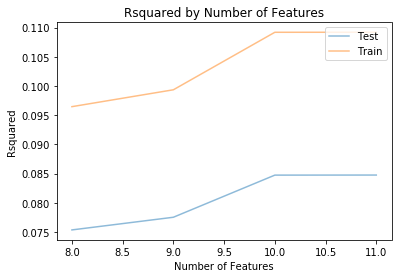

In [29]:
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 20, 10, 5]
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

In [58]:
#predicting the values of linear regression model
y_test_preds = lm_model.predict(X_test)

preds_vs_act = pd.DataFrame(np.hstack([y_test.values.reshape(y_test.size,1), y_test_preds.reshape(y_test.size,1)]))
preds_vs_act.columns = ['actual', 'preds']
preds_vs_act['diff'] = preds_vs_act['actual'] - preds_vs_act['preds']

#plt.plot(preds_vs_act['preds'], preds_vs_act['diff'], 'bo');
#plt.xlabel('predicted');
#plt.ylabel('difference');

In [31]:
print("""
        Mean Squared Error: {}
        R2 Score: {}
        Mean Absolute Error: {}
     """.format(
        np.sqrt(mean_squared_error(y_test, y_test_preds)),
        r2_score(y_test,y_test_preds) * 100,
        mean_absolute_error(y_test,y_test_preds)
        ))


        Mean Squared Error: 252.51570113973548
        R2 Score: 8.475697986448793
        Mean Absolute Error: 74.75161606736405
     


In [32]:
### Now we can see the actual value and prediction value and the difference of both the value 
preds_vs_act = pd.DataFrame(np.hstack([y_test.values.reshape(y_test.size,1), y_test_preds.reshape(y_test.size,1)]))
preds_vs_act.columns = ['actual', 'preds']
preds_vs_act['diff'] = preds_vs_act['actual'] - preds_vs_act['preds']
preds_vs_act.head()

,actual,preds,diff
0,45.0,94.022593,-49.022593
1,85.0,255.960898,-170.960898
2,192.0,289.559224,-97.559224
3,120.0,204.901304,-84.901304
4,190.0,246.586607,-56.586607


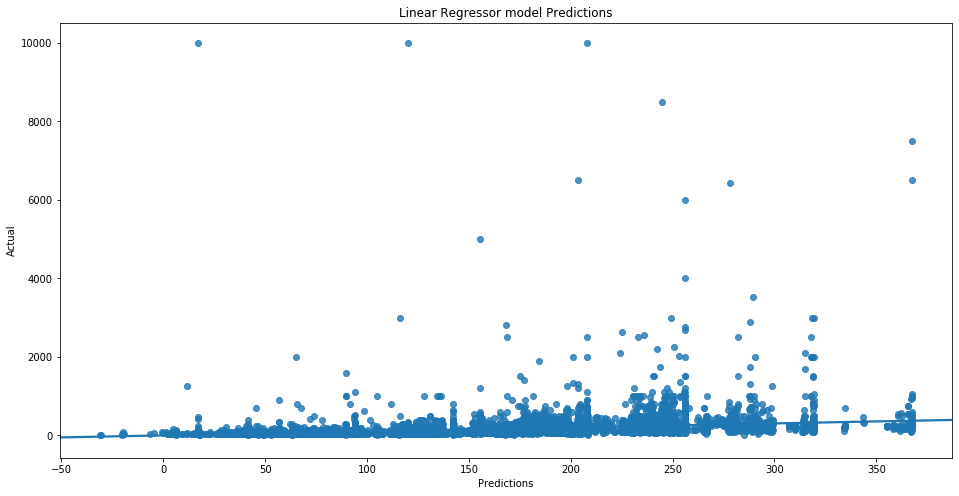

In [55]:
plt.figure(figsize=(16,8))
sns.regplot(y_test_preds,y_test)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title("Linear Regressor model Predictions")
plt.show()

In [35]:
coefs_df = pd.DataFrame()

coefs_df['est_int'] = X_train.columns
coefs_df['coefs'] = lm_model.coef_
coefs_df['abs_coefs'] = np.abs(lm_model.coef_)

coefs_df.sort_values('abs_coefs', ascending=False).head(20)

,est_int,coefs,abs_coefs
10,room_type_Shared room,-150.874011,150.874011
9,room_type_Private room,-113.782875,113.782875
6,neighbourhood_group_Manhattan,87.875017,87.875017
2,all_year_avail,67.147051,67.147051
3,no_review,48.155430,48.155430
5,neighbourhood_group_Brooklyn,35.475915,35.475915
4,low_avail,-20.457716,20.457716
7,neighbourhood_group_Queens,10.912439,10.912439
8,neighbourhood_group_Staten Island,8.274038,8.274038
0,calculated_host_listings_count,-0.100452,0.100452


In [36]:
lm_model.intercept_

140.48861895393796

### Here, there are many outliers in this data set, so linear regression model doesn't works well on outliers. So, we use Gradient Bossting regression model to predict our model.

In [46]:
from sklearn.ensemble import GradientBoostingRegressor

In [47]:
'''Gradient Boosted Regressor'''
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.01)
GBoost.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [48]:
'''Get Predictions & Metrics'''
predicts2 = GBoost.predict(X_test)

print("""
        Mean Squared Error: {}
        R2 Score: {}
        Mean Absolute Error: {}
     """.format(
        np.sqrt(mean_squared_error(y_test, predicts2)),
        r2_score(y_test,predicts2) * 100,
        mean_absolute_error(y_test,predicts2)
        ))


        Mean Squared Error: 247.70521990607995
        R2 Score: 11.92960011757852
        Mean Absolute Error: 70.56944291376236
     


In [61]:
### Now we can see the actual value and prediction value and the difference of both the value 
preds_vs_act2 = pd.DataFrame(np.hstack([y_test.values.reshape(y_test.size,1), predicts2.reshape(y_test.size,1)]))
preds_vs_act2.columns = ['actual', 'preds']
preds_vs_act2['diff'] = preds_vs_act['actual'] - preds_vs_act['preds']
preds_vs_act2.head()

,actual,preds,diff
0,45.0,86.485962,-49.022593
1,85.0,258.048281,-170.960898
2,192.0,221.718196,-97.559224
3,120.0,149.215760,-84.901304
4,190.0,264.711909,-56.586607


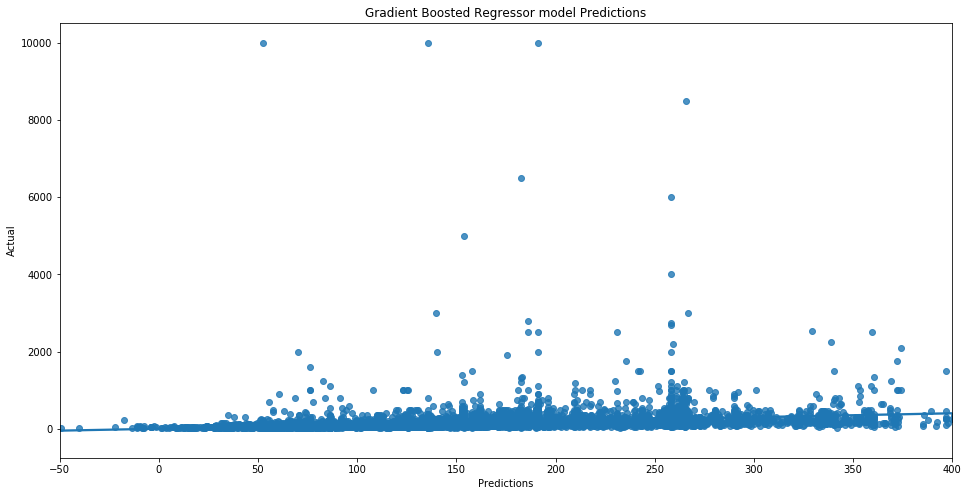

In [57]:
plt.figure(figsize=(16,8))
sns.regplot(predicts2,y_test)
plt.xlabel('Predictions')
plt.xlim((-50,400))
plt.ylabel('Actual')
plt.title("Gradient Boosted Regressor model Predictions")
plt.show()